<a href="https://colab.research.google.com/github/ManjunathAdi/Notebooks/blob/main/Coding_RecursiveAI_V4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recursive technical homework

## Motivation
We hope you have fun doing this task as well as learn something new.

Do not be discouraged if you find the task challenging. Feel free to research as much as you want on Google or any other resource to solve this task. You are welcome to copy code snippets from stackoverflow, tutorials, blog posts, etc to help you finish the task. Make sure you understand them though :)

The goal is to push yourself a little and see how you like solving new problems using scientific computing and data analysis.

**About colab**

Please create a duplicate of this notebook using File > Save a Copy in Drive. Share your solution via a link to your local copy of the notebook.

You can solve the entirety of this task using a free kernel running in the cloud. Just click 'Connect' on the top right of the notebook. You can use any python libraries you want *unless* explicitly told to code your own algorithm. If a library you want to use is not already available from the colab runtime, go to 'Help' > 'Search code snippets' > Type 'Importing a library that is not in Colab' to learn how to install a library using pip.


# Part 1
Understanding Stochastic Gradient Descent.
In this exercise, we want to implement [Stochastic Gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) without using a built-in optimizer, to understand how parameters are optimized at the low level.

Let's consider a toy problem of [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression). The data generation process is such that we have one floating point variable $x \in [0,1]$, and one categorical variable $y\in \{0,1\}$. The Logistic Regression problem is to find the optimal parameters for the logistic function to predict the probability of $y$ given $x$.

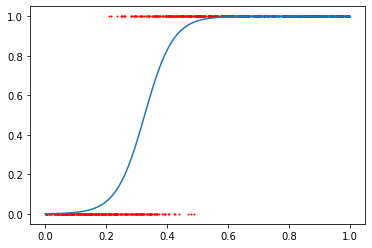

In the image above, the x and y axis correspond to the variables defined previously, with the red "dots" the true data as generated by the process defined below, and the blue line is the optimal logistic decision function learned from the data.

The optimal parameters can be found numerically using gradient descent. In this case, we will be using SGD (batched gradient descent) to optimize the two parameters in the logistic function, $\beta_1, \beta_2$.

If ${p(x)={\frac {1}{1+e^{-(\beta _{1}+\beta _{2}x)}}}}$, then we want to find $\beta_1, \beta_2$ such that the [negative log likelihood](https://en.wikipedia.org/wiki/Likelihood_function) is minimized. In this case, ${\ell =\sum _{k=1}^{K}\left(\,y_{k}\ln(p_{k})+(1-y_{k})\ln(1-p_{k})\right)}$, and the SGD formula is simply:
$\beta_i = \beta_{i-1} - \alpha * \nabla \ell$.

The data generation process as well as the pseudo-code is provided for you below, your task is to fill in the appropriate pytorch code. *Do not use the built-in optimizer*, implement SGD using tensor operations alone.


In [22]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn

In [2]:
def generate_data():
  data = torch.rand(1000, 2)
  label = ((data[:,0]+0.3*data[:,1]) > 0.5).to(torch.int)
  return data[:,0], label

In [3]:
#  Logistic regression model
def logistic_function(x, beta1, beta2):
    return 1 / (1 + torch.exp(-(beta1 + beta2 * x)))

#  Negative log likelihood loss function
def negative_log_likelihood(y, p):
    return -torch.mean(y * torch.log(p) + (1 - y) * torch.log(1 - p))

#  Gradient Descent Update Function (SGD)
def sgd_update(beta1, beta2, beta1_grad, beta2_grad, learning_rate):
    beta1 -= learning_rate * beta1_grad
    beta2 -= learning_rate * beta2_grad
    return beta1, beta2

In [4]:

input, label = generate_data()

# Make minibatches.
inputs = torch.split(input, 32)
labels = torch.split(label, 32)

# Define the two variables to optimize
b1 = torch.autograd.Variable(torch.tensor([0.01]), requires_grad=True)
b2 = torch.autograd.Variable(torch.tensor([0.01]), requires_grad=True)

# Hyperparameters
learning_rate = 0.1
epochs = 1000

for epoch in range(epochs):
  for x, y in zip(inputs,labels):
    # Calculate p_x as per formula above
    p = logistic_function(x, b1, b2)
    # Calculate the negative loss likelihood
    loss = negative_log_likelihood(y, p)
    # Zero gradients before backward pass
    if b1.grad is not None:
        b1.grad.zero_()
    if b2.grad is not None:
        b2.grad.zero_()
    # Calculate the gradient of the loss w.r.t. the inputs
    loss.backward()
    # Update the parameters b according to SGD formula
    with torch.no_grad():  # Disable gradient tracking during parameter update
        b1, b2 = sgd_update(b1, b2, b1.grad, b2.grad, learning_rate)

    # Print out the loss value
  if epoch % 100 == 0:
      print(f'Epoch {epoch}, Loss: {loss.item()}')


Epoch 0, Loss: 0.5043952465057373
Epoch 100, Loss: 0.2273077815771103
Epoch 200, Loss: 0.22426533699035645
Epoch 300, Loss: 0.22757366299629211
Epoch 400, Loss: 0.2315659373998642
Epoch 500, Loss: 0.235331729054451
Epoch 600, Loss: 0.2386968433856964
Epoch 700, Loss: 0.24165742099285126
Epoch 800, Loss: 0.24424977600574493
Epoch 900, Loss: 0.24651947617530823


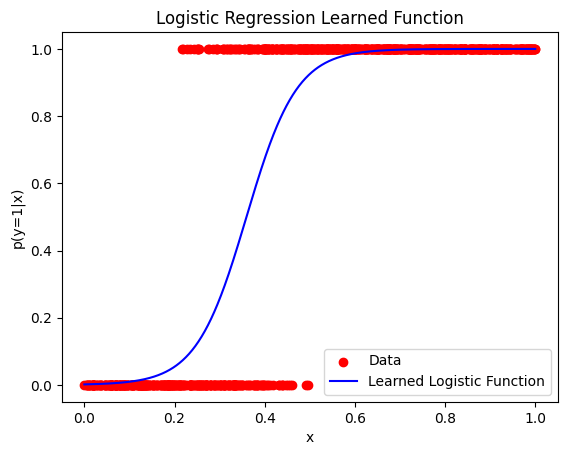

Learned beta1: -6.446579933166504, Learned beta2: 17.925979614257812


In [5]:
# Visualizing the learned decision boundary
x_vals = np.linspace(0, 1, 1000).reshape(-1, 1)
x_vals_tensor = torch.tensor(x_vals, dtype=torch.float32)
predicted_probs = logistic_function(x_vals_tensor, b1, b2).detach().numpy()

plt.scatter(input.numpy(), label.numpy(), color='red', label='Data')
plt.plot(x_vals, predicted_probs, color='blue', label='Learned Logistic Function')
plt.xlabel('x')
plt.ylabel('p(y=1|x)')
plt.title('Logistic Regression Learned Function')
plt.legend()
plt.show()

# Print final parameters
print(f'Learned beta1: {b1.item()}, Learned beta2: {b2.item()}')

# Part 2-1

Researchers have measured a bivariate timeseries, but the equipment was unreliable so the data has gaps as well as noise. The data can be found in [data.csv](https://gist.github.com/tmramalho/51733432c88e2b834dbd70353849f887)

In this exercise, we want to train an [MLP](https://en.wikipedia.org/wiki/Multilayer_perceptron) to regress the full observed trajectory from the measured data. Formally, the MLP will be used to approximate the function $f:\mathbb{R} \rightarrow \mathbb{R}^2 ; f(t) = (x(t), y(t))$. In other words, the model takes the current time as an input, and predicts the values of `x` and `y` at that time based only on the measured data.

Your task is to define the data loader, the MLP model and the loss function to complete this task successfully. For this problem you will need to use a regression loss, not a classification loss.

Successful training should result in a data interpolation similar to the below:
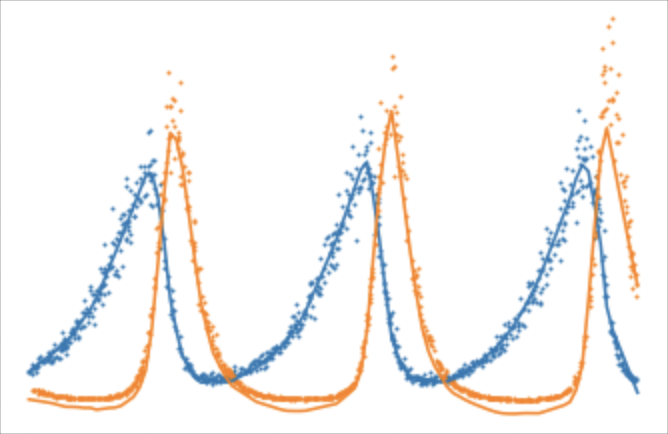

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np

In [2]:
class Net(nn.Module):
    '''Model to regress 2d time series values given scalar input.'''
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Net, self).__init__()
        #TODO
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)


    def forward(self, x):
        #TODO
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [3]:
# Parameters
input_dim = 1  # Timestamp as input
hidden_dim = 512  # Number of neurons in hidden layers
output_dim = 2  # Output is (x, y)

In [4]:
class TimeSeriesDataset(torch.utils.data.Dataset):

    def __init__(self, time, targets):
        #TODO
        self.time = time
        self.targets = targets

    def __len__(self):
        #TODO
        return len(self.time)

    def __getitem__(self, idx):
        #TODO
        return self.time[idx], self.targets[idx]

In [5]:
BATCH_SIZE = 32

In [6]:
df = pd.read_csv('https://gist.githubusercontent.com/tmramalho/51733432c88e2b834dbd70353849f887/raw/data.csv')
df.shape, df.head()

((2000, 3),
       t                   x                   y
 0  0.00                   -  0.5759052335487023
 1  0.01                   -                   -
 2  0.02  1.1159124144549086                   -
 3  0.03                   -                   -
 4  0.04  1.0054825084650338  0.4775267298487888)

In [7]:
df.dtypes

,0
t,float64
x,object
y,object


In [8]:
# Replace '-' and 'NaN' with np.nan
df.replace(['-', 'NaN'], np.nan, inplace=True)

In [9]:
df.isnull().sum() # number of missing values

,0
t,0
x,1181
y,1173


In [10]:
df['x'] = pd.to_numeric(df['x'], errors='coerce')
df['y'] = pd.to_numeric(df['y'], errors='coerce')
df.dtypes

,0
t,float64
x,float64
y,float64


In [11]:
df.interpolate(method='linear', inplace=True)

In [12]:
df.isnull().sum()

,0
t,0
x,2
y,0


In [13]:
df.head()

,t,x,y
0,0.00,NaN,0.575905
1,0.01,NaN,0.551311
2,0.02,1.115912,0.526716
3,0.03,1.060697,0.502121
4,0.04,1.005483,0.477527


In [14]:
df[2:].head()

,t,x,y
2,0.02,1.115912,0.526716
3,0.03,1.060697,0.502121
4,0.04,1.005483,0.477527
5,0.05,1.053657,0.468851
6,0.06,1.101832,0.460175


In [15]:
df = df[2:]

In [16]:
from sklearn.preprocessing import StandardScaler

In [17]:
# Extract features and targets
time = df['t'].values.reshape(-1, 1)  # Feature: time
x_values = df['x'].values  # Target: x values
y_values = df['y'].values  # Target: y values

# Standardize features (optional but recommended for neural networks)
scaler = StandardScaler()
time = scaler.fit_transform(time)

# Convert to PyTorch tensors
time_tensor = torch.tensor(time, dtype=torch.float32)
x_tensor = torch.tensor(x_values, dtype=torch.float32)
y_tensor = torch.tensor(y_values, dtype=torch.float32)

# Combine targets into a single tensor
targets_tensor = torch.stack([x_tensor, y_tensor], dim=1)

In [18]:
dataset = TimeSeriesDataset(time_tensor, targets_tensor)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

def loss_fn(outputs, labels):
  #TODO
  return F.mse_loss(outputs, labels)

net = Net(input_dim, hidden_dim, output_dim)

optimizer = optim.Adam(net.parameters(), lr=0.001)   #TODO what is a good optimizer?

###

In [19]:
for epoch in range(300):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 20 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0

print('Finished Training')

[1,    20] loss: 7.949
[1,    40] loss: 6.440
[1,    60] loss: 5.689
[2,    20] loss: 5.803
[2,    40] loss: 5.419
[2,    60] loss: 5.225
[3,    20] loss: 5.295
[3,    40] loss: 4.695
[3,    60] loss: 4.352
[4,    20] loss: 4.388
[4,    40] loss: 3.882
[4,    60] loss: 3.603
[5,    20] loss: 3.315
[5,    40] loss: 3.221
[5,    60] loss: 2.965
[6,    20] loss: 2.644
[6,    40] loss: 2.366
[6,    60] loss: 2.384
[7,    20] loss: 1.951
[7,    40] loss: 2.094
[7,    60] loss: 1.815
[8,    20] loss: 1.620
[8,    40] loss: 1.556
[8,    60] loss: 1.762
[9,    20] loss: 1.460
[9,    40] loss: 1.338
[9,    60] loss: 1.265
[10,    20] loss: 1.342
[10,    40] loss: 1.161
[10,    60] loss: 1.394
[11,    20] loss: 1.058
[11,    40] loss: 1.120
[11,    60] loss: 1.037
[12,    20] loss: 1.115
[12,    40] loss: 0.938
[12,    60] loss: 0.933
[13,    20] loss: 1.059
[13,    40] loss: 0.930
[13,    60] loss: 1.090
[14,    20] loss: 1.114
[14,    40] loss: 0.932
[14,    60] loss: 0.717
[15,    20] loss: 0

In [20]:
# Plot results to validate training

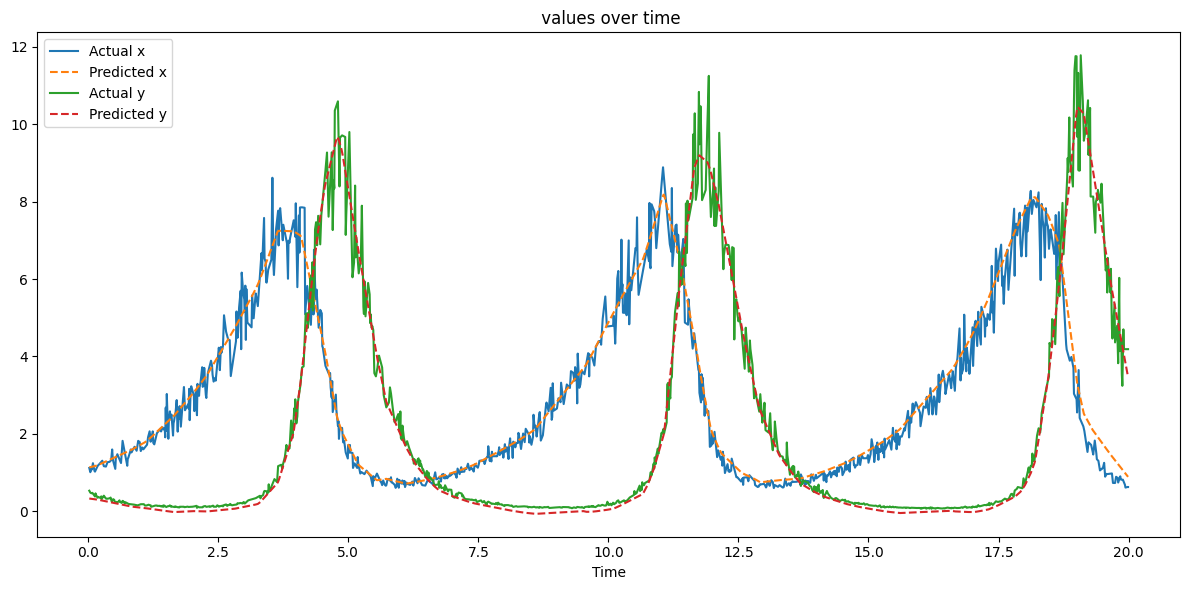

In [23]:
# Evaluate the model
net.eval()
with torch.no_grad():
    predictions = net(time_tensor).numpy()
    time_original = scaler.inverse_transform(time)  # Inverse transform time for plotting

# Plot results
plt.figure(figsize=(12, 6))

plt.plot(time_original, x_tensor.numpy(), label='Actual x')
plt.plot(time_original, predictions[:, 0], label='Predicted x', linestyle='--')
plt.xlabel('Time')
plt.legend()

plt.plot(time_original, y_tensor.numpy(), label='Actual y')
plt.plot(time_original, predictions[:, 1], label='Predicted y', linestyle='--')
plt.legend()
plt.title(' values over time')

plt.tight_layout()
plt.show()

# Part 2-2 Time-series extension

The simplified model above will only work well if $t\in[0,20]$.
Create a different model that can extrapolate `x,y` predictions to $t>20$.
Assume that the model has access to the same data as above, and is tasked to predict up to $t=100$. You can change anything in the above setup as needed, including model architecture, loss function, training procedure or data loader.

There are several different correct approaches to tackle this problem, all with different pros and cons, so make sure to explain your reasoning for the different choices made.


In [ ]:
'''

Approaches for Extrapolation
Extrapolation is more challenging than interpolation because it requires the model to make predictions outside the range of the training data.
some strategies to improve extrapolation:

Enhance Model Complexity: Use more complex models that can better capture the underlying trends and patterns in the data.
This might include deeper neural networks or incorporating more sophisticated architectures like Recurrent Neural Networks (RNNs)
or Long Short-Term Memory (LSTM) networks.


Explanation of Choices

- it is not the approach that always gets us the best extrapolation. what is the type of pattern in time series and time series analysis is
most important to decide what approach for extrapolation and also for further modelling and other tasks.

Methos 1-
LSTM Model: LSTM networks are suited for sequential data and can learn temporal dependencies, which are crucial for extrapolation beyond the observed range.
3D Input Format: LSTM requires 3D input where the sequence length is one dimension.

Method 2-
Seq2Seq RNN with dynamic feedback at decoder for extrapolation


 '''




In [45]:
#time = data['time'].values
targets = np.stack([x_values, y_values], axis=1)

# Hyperparameters
sequence_length = 48  # Sequence length for LSTM
batch_size = 32

In [46]:
class SeqTimeSeriesDataset(torch.utils.data.Dataset):
    '''Dataset for time-series data for LSTM'''
    def __init__(self, time, targets, sequence_length):
        self.time = time
        self.targets = targets
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.time) - self.sequence_length

    def __getitem__(self, idx):
        time_seq = self.time[idx:idx + self.sequence_length]
        target_seq = self.targets[idx:idx + self.sequence_length]
        return torch.tensor(time_seq, dtype=torch.float32), torch.tensor(target_seq, dtype=torch.float32)

# Create dataset and data loader
dataset = SeqTimeSeriesDataset(time, targets, sequence_length)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [47]:
class LSTMNet(nn.Module):
    '''LSTM model for regressing x(t), y(t) given a sequence of time inputs'''

    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(LSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # LSTM output (batch, seq_len, hidden_size)
        predictions = self.fc(lstm_out)  # Linear layer for predictions (batch, seq_len, output_size)
        return predictions


In [48]:
# Define model, loss function, and optimizer
input_size = 1  # Single feature (time)
hidden_size = 64
output_size = 2  # Predict x(t) and y(t)
num_layers = 2

model = LSTMNet(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training Loop
num_epochs = 300

In [49]:


for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        # Reshape inputs (batch, seq_len, input_size) and labels (batch, seq_len, output_size)
#        inputs = inputs.view(batch_size, sequence_length, input_size)
#        labels = labels.view(batch_size, sequence_length, output_size)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 20 == 19:  # Print every 20 mini-batches
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 20:.3f}')
            running_loss = 0.0

print('Finished Training')

[Epoch 1, Batch 20] loss: 7.544
[Epoch 1, Batch 40] loss: 7.347
[Epoch 1, Batch 60] loss: 7.121
[Epoch 2, Batch 20] loss: 7.278
[Epoch 2, Batch 40] loss: 6.962
[Epoch 2, Batch 60] loss: 6.613
[Epoch 3, Batch 20] loss: 7.206
[Epoch 3, Batch 40] loss: 6.839
[Epoch 3, Batch 60] loss: 6.743
[Epoch 4, Batch 20] loss: 6.995
[Epoch 4, Batch 40] loss: 6.826
[Epoch 4, Batch 60] loss: 7.052
[Epoch 5, Batch 20] loss: 6.658
[Epoch 5, Batch 40] loss: 6.953
[Epoch 5, Batch 60] loss: 6.944
[Epoch 6, Batch 20] loss: 6.785
[Epoch 6, Batch 40] loss: 6.919
[Epoch 6, Batch 60] loss: 7.118
[Epoch 7, Batch 20] loss: 6.779
[Epoch 7, Batch 40] loss: 6.957
[Epoch 7, Batch 60] loss: 7.055
[Epoch 8, Batch 20] loss: 6.882
[Epoch 8, Batch 40] loss: 6.356
[Epoch 8, Batch 60] loss: 6.099
[Epoch 9, Batch 20] loss: 6.073
[Epoch 9, Batch 40] loss: 5.219
[Epoch 9, Batch 60] loss: 5.386
[Epoch 10, Batch 20] loss: 5.036
[Epoch 10, Batch 40] loss: 4.567
[Epoch 10, Batch 60] loss: 5.113
[Epoch 11, Batch 20] loss: 4.984
[Epo

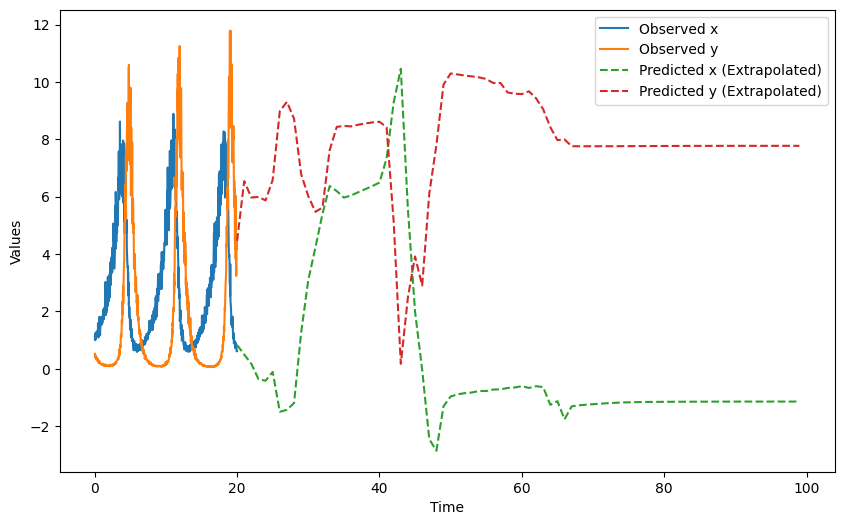

In [50]:
# Extrapolation
model.eval()
future_time_steps = np.arange(20, 100, 1)  # Predict from t = 20 to t = 100
predicted_values = []

# Start with the last known sequence from the dataset
with torch.no_grad():
    # Take the last sequence from the known data for extrapolation
    last_sequence = torch.tensor(time[-sequence_length:], dtype=torch.float32).view(1, sequence_length, 1)

    for t in future_time_steps:
        # Predict x(t), y(t) for the next time step
        predicted = model(last_sequence)
        predicted_values.append(predicted[:, -1, :].numpy()[0])  # Take the last prediction in the sequence

        # Update the sequence by appending the new time step
        new_time_step = torch.tensor([[t]], dtype=torch.float32).unsqueeze(0)
        last_sequence = torch.cat([last_sequence[:, 1:, :], new_time_step], dim=1)

predicted_values = np.array(predicted_values)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(time_original, x_tensor.numpy(), label='Observed x')
plt.plot(time_original, y_tensor.numpy(), label='Observed y')

# Plot extrapolated x(t) and y(t)
plt.plot(future_time_steps, predicted_values[:, 0], label='Predicted x (Extrapolated)', linestyle='dashed')
plt.plot(future_time_steps, predicted_values[:, 1], label='Predicted y (Extrapolated)', linestyle='dashed')

plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()


In [51]:
# # # # #   SEQ2SEQ RNN model with dynamic feedback at decoder RNN. ###################################

In [ ]:
'''
To add dynamic feedback to the decoder RNN in the Seq2Seq model, we need to modify the decoder to allow the output of one time step to be fed
back as the input to the next time step. This is known as autoregressive decoding, where the decoder generates one prediction at a time and
uses the previous prediction as the input for the next time step.

Key Concepts:
Encoder: The encoder processes the input time sequence and outputs a context vector (hidden states).
Decoder with Dynamic Feedback: The decoder generates one time step prediction at a time. Each output at time step t is fed back as the input
for time step t+1.
In this approach:

We initialize the decoder input with the last known value (or a special token).
At each step, we take the predicted value from the decoder and feed it back as the input for the next time step.
'''

In [90]:
# TimeSeriesDataset for Seq2Seq model
class QTimeSeriesDataset(torch.utils.data.Dataset):
    '''Dataset for time-series data for Seq2Seq'''

    def __init__(self, time, targets, sequence_length):
        self.time = time
        self.targets = targets
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.time) - self.sequence_length

    def __getitem__(self, idx):
        time_seq = self.time[idx:idx + self.sequence_length]
        target_seq = self.targets[idx:idx + self.sequence_length]
        return torch.tensor(time_seq, dtype=torch.float32), torch.tensor(target_seq, dtype=torch.float32)

#time = data['time'].values
targets = np.stack([x_values, y_values], axis=1)

# Hyperparameters
sequence_length = 48  # Sequence length for the encoder
batch_size = 32

# Create dataset and data loader
qdataset = QTimeSeriesDataset(time, targets, sequence_length)
trainloader = torch.utils.data.DataLoader(qdataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [91]:
class Encoder(nn.Module):
    '''Encoder for the Seq2Seq model'''

    def __init__(self, input_size, hidden_size, num_layers=1):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        outputs, hidden = self.lstm(x)
        return hidden  # Return the hidden and cell states (context vector)

class DecoderWithDynamicFeedback(nn.Module):
    '''Decoder with dynamic feedback for the Seq2Seq model'''

    def __init__(self, output_size, hidden_size, num_layers=1):
        super(DecoderWithDynamicFeedback, self).__init__()
        self.lstm = nn.LSTM(output_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, decoder_input, hidden, seq_len):
        batch_size = decoder_input.shape[0]
        output_size = decoder_input.shape[2]

        # Initialize the output tensor to hold the predictions
        outputs = torch.zeros(batch_size, seq_len, output_size).to(decoder_input.device)

        for t in range(seq_len):
            lstm_out, hidden = self.lstm(decoder_input, hidden)
            predictions = self.fc(lstm_out)  # Linear layer for predictions
            outputs[:, t, :] = predictions.squeeze(1)

            # Feedback the predicted output as the next input
            decoder_input = predictions  # Predicted output becomes next input

        return outputs, hidden




In [92]:
class Seq2SeqWithFeedback(nn.Module):
    '''Seq2Seq model with dynamic feedback in the decoder'''

    def __init__(self, encoder, decoder):
        super(Seq2SeqWithFeedback, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg, seq_len):
        hidden = self.encoder(src)

        initial_input = trg[:, 0, :].unsqueeze(1)  # Initial input to the decoder (first time step)
        outputs, hidden = self.decoder(initial_input, hidden, seq_len)

        return outputs


In [93]:
# Define the encoder, decoder, and seq2seq model
input_size = 1  # Single feature (time)
hidden_size = 64
output_size = 2  # Predict x(t) and y(t)
num_layers = 1

encoder = Encoder(input_size, hidden_size, num_layers)
decoder = DecoderWithDynamicFeedback(output_size, hidden_size, num_layers)
model = Seq2SeqWithFeedback(encoder, decoder)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 100
seq_len = sequence_length

In [94]:

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        # Reshape inputs (batch_size, seq_len, 1) and labels (batch_size, seq_len, 2)
        inputs = inputs.view(inputs.size(0), -1, 1)
        labels = labels.view(labels.size(0), -1, output_size)

        optimizer.zero_grad()

        outputs = model(inputs, labels, seq_len)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 20 == 19:  # Print every 20 mini-batches
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 20:.3f}')
            running_loss = 0.0

print('Finished Training')


[Epoch 1, Batch 20] loss: 11.717
[Epoch 1, Batch 40] loss: 8.248
[Epoch 1, Batch 60] loss: 7.013
[Epoch 2, Batch 20] loss: 6.707
[Epoch 2, Batch 40] loss: 6.812
[Epoch 2, Batch 60] loss: 7.177
[Epoch 3, Batch 20] loss: 7.080
[Epoch 3, Batch 40] loss: 6.669
[Epoch 3, Batch 60] loss: 5.873
[Epoch 4, Batch 20] loss: 7.403
[Epoch 4, Batch 40] loss: 7.753
[Epoch 4, Batch 60] loss: 7.171
[Epoch 5, Batch 20] loss: 6.973
[Epoch 5, Batch 40] loss: 6.465
[Epoch 5, Batch 60] loss: 6.467
[Epoch 6, Batch 20] loss: 6.681
[Epoch 6, Batch 40] loss: 6.343
[Epoch 6, Batch 60] loss: 6.146
[Epoch 7, Batch 20] loss: 5.894
[Epoch 7, Batch 40] loss: 5.698
[Epoch 7, Batch 60] loss: 5.076
[Epoch 8, Batch 20] loss: 3.943
[Epoch 8, Batch 40] loss: 2.932
[Epoch 8, Batch 60] loss: 2.075
[Epoch 9, Batch 20] loss: 1.621
[Epoch 9, Batch 40] loss: 1.578
[Epoch 9, Batch 60] loss: 1.395
[Epoch 10, Batch 20] loss: 1.309
[Epoch 10, Batch 40] loss: 1.092
[Epoch 10, Batch 60] loss: 1.314
[Epoch 11, Batch 20] loss: 1.562
[Ep

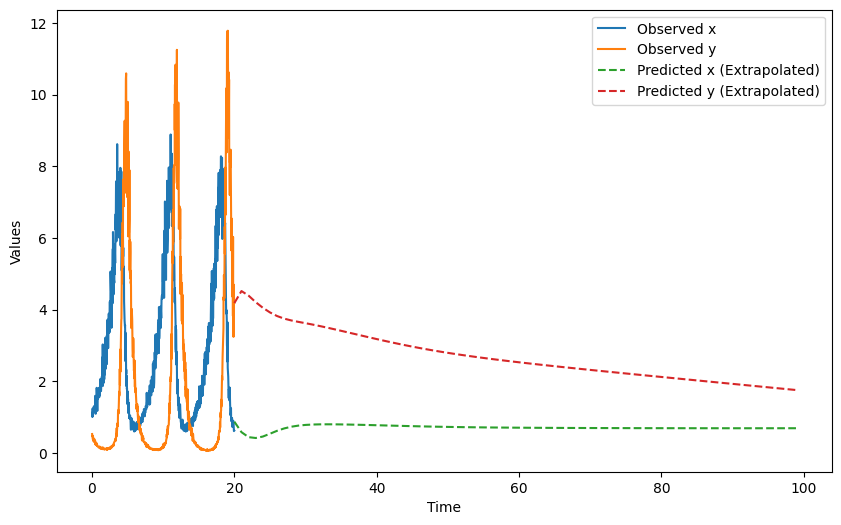

In [101]:
# Extrapolation with dynamic feedback
model.eval()
future_time_steps = np.arange(20, 100, 1)  # Predict from t = 20 to t = 100
predicted_values = []

with torch.no_grad():
    # Use the last known sequence from the dataset to seed the encoder
    last_sequence = torch.tensor(time[-sequence_length:], dtype=torch.float32).view(1, sequence_length, 1)
    targets_sequence = torch.tensor(targets[-sequence_length:], dtype=torch.float32).view(1, sequence_length, 2)

    # Encode the last sequence
    hidden = model.encoder(last_sequence)

    # Initialize the decoder input as the last x(t), y(t) from the known data
    decoder_input = targets_sequence[:, -1, :].unsqueeze(1)  # Initial input to the decoder

    # Generate future predictions one time step at a time
    for t in future_time_steps:
        predicted, hidden = model.decoder(decoder_input, hidden, 1)
        predicted_values.append(predicted.squeeze(1).numpy()[0])

        # Feedback the predicted output as the input for the next time step
        decoder_input = predicted.unsqueeze(1)[0]

predicted_values = np.array(predicted_values)

# Plot the results
import matplotlib.pyplot as plt

times = dataset.time
plt.figure(figsize=(10, 6))
plt.plot(time_original, x_tensor.numpy(), label='Observed x')
plt.plot(time_original, y_tensor.numpy(), label='Observed y')

# Plot extrapolated x(t) and y(t)
plt.plot(future_time_steps, predicted_values[:, 0], label='Predicted x (Extrapolated)', linestyle='dashed')
plt.plot(future_time_steps, predicted_values[:, 1], label='Predicted y (Extrapolated)', linestyle='dashed')

plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()


In [ ]:
############# SEQ2SEQ END

# Part 3-1a

Please implement the below function `min_dist`. This function should take a sparse list of 2D coordinates, and map them to a 2D tensor of a specified resolution. The values of each pixel in the tensor should correspond to the [euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) between that pixel and the closest pixel which contains a data point.

You can use either numpy or pytorch tensor operations to implement the function. Use only tensor operations, no for-loops are necessary.

Here are the example outputs for the two test cases highlighted below:

Case 1: data at `[0.4, 0.3], [0.6, 0.7]`, resolution 20 pixels.

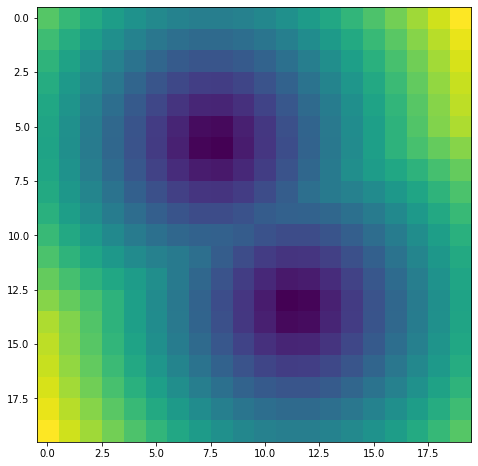


Case 2: data at `[0.4, 0.3], [0.6, 0.7], [0.3, 0.8], [0.5, 0.2]`, resolution 256 pixels.

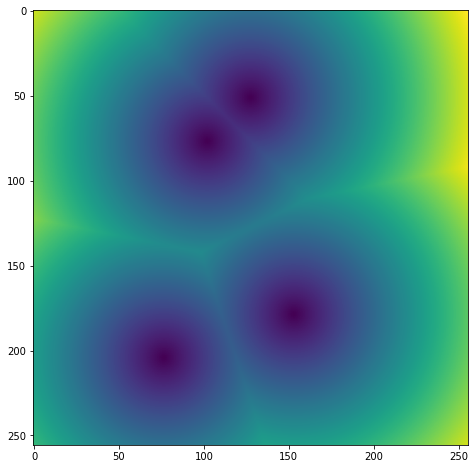


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import numpy as np

def min_dist(points, res):
    x = np.linspace(0, 1, res)
    y = np.linspace(0, 1, res)
    X, Y = np.meshgrid(x, y)
    X_flat = X.flatten()
    Y_flat = Y.flatten()

    # using broadcasting
    X_flat_expanded = X_flat[:, np.newaxis]  # Shape (res*res, 1)
    Y_flat_expanded = Y_flat[:, np.newaxis]  # Shape (res*res, 1)
    points_expanded = np.array(points)  # Shape (num_points, 2)

    distances = np.sqrt(
        (X_flat_expanded - points_expanded[:, 0]) ** 2 +
        (Y_flat_expanded - points_expanded[:, 1]) ** 2
    )  # Shape (res*res, num_points)

    # Get the minimum distance for each pixel
    min_distances = np.min(distances, axis=1)
    # Reshape to the desired tensor shape
    min_dist_tensor = min_distances.reshape((res, res))

    return min_dist_tensor


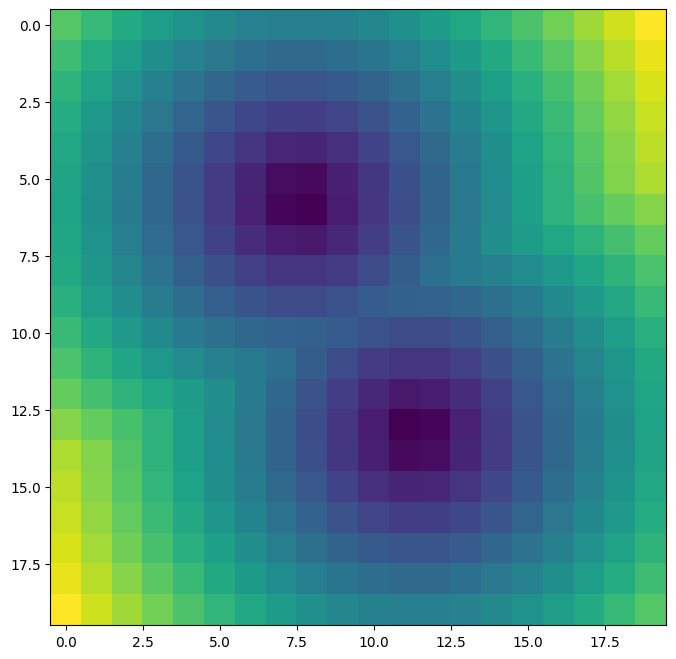

In [ ]:
# Case 1:
distance_to_data = min_dist([[0.4, 0.3], [0.6, 0.7]], 20)
plt.figure(figsize=(8, 8))
plt.imshow(distance_to_data)

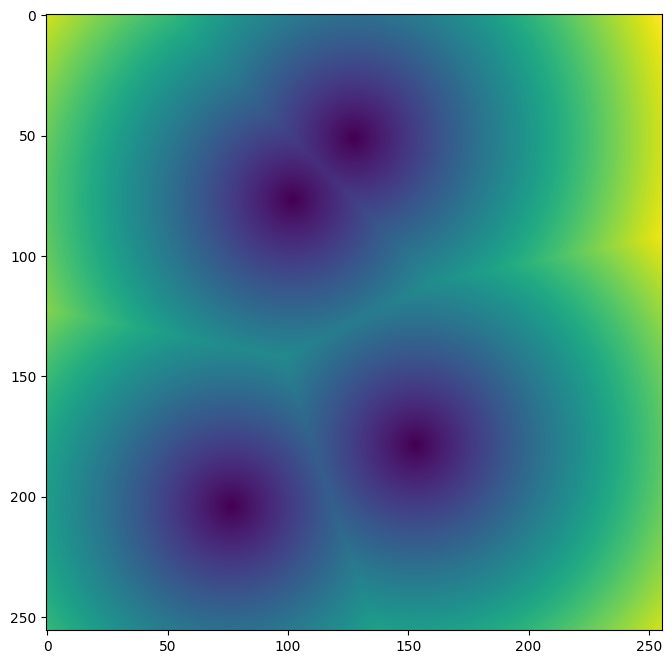

In [ ]:
# Case 2:
distance_to_data = min_dist([[0.4, 0.3], [0.6, 0.7], [0.3, 0.8], [0.5, 0.2]], 256)
plt.figure(figsize=(8, 8))
plt.imshow(distance_to_data)

# Part 3-1b: Batched version

As a next step, improve the `min_dist` function to support batches.
The `points` array is now expected to be a tensor with shape [batch_size, num_points, 3], generated by `create_points`.
`min_dist` should return a batch of maps with shape [batch_size, res, res].
Again, make sure to implement `min_dist` using **no for-loops**.
Demonstrate your function output with `batch_size=3` and `num_points=4`.

In [ ]:
def create_points(batch_size, num_points):
  coords = np.random.rand(batch_size, num_points, 2)
  return coords

In [ ]:
import numpy as np

In [ ]:
def compute_min_distances(points, res):
    batch_size, num_points, _ = points.shape
    X_flat_expanded = np.linspace(0, 1, res)
    Y_flat_expanded = np.linspace(0, 1, res)
    # Create meshgrid from flattened grid coordinates
    X_grid, Y_grid = np.meshgrid(X_flat_expanded, Y_flat_expanded, indexing='ij')

    # Flatten the grid coordinates to match the shape (res * res,)
    X_grid_flat = X_grid.flatten()
    Y_grid_flat = Y_grid.flatten()

    # Expand dimensions to match (batch_size, num_points, res * res)
    X_grid_expanded = X_grid_flat[np.newaxis, np.newaxis, :]  # Shape (1, 1, res * res)
    Y_grid_expanded = Y_grid_flat[np.newaxis, np.newaxis, :]  # Shape (1, 1, res * res)

    # Expand points dimensions to match (batch_size, num_points, res * res)
    points_expanded_x = points[:, :, np.newaxis, 0]  # Shape (batch_size, num_points, 1)
    points_expanded_y = points[:, :, np.newaxis, 1]  # Shape (batch_size, num_points, 1)

    # Calculate distances using broadcasting
    distances = np.sqrt(
        (X_grid_expanded - points_expanded_x) ** 2 +
        (Y_grid_expanded - points_expanded_y) ** 2
    )  # Shape (batch_size, num_points, res * res)

    # Find the minimum distance for each grid point
    min_distances = np.min(distances, axis=1)  # Shape (batch_size, res * res)

    # Reshape to (batch_size, res, res)
    min_dist_tensor = min_distances.reshape((batch_size, res, res))

    return min_dist_tensor


In [ ]:
# Example usage:
batch_size = 10
num_points = 5
res = 20
points = np.random.rand(batch_size, num_points, 2)
points = create_points(batch_size, num_points)

min_dist_tensor = compute_min_distances(points, res)
print(min_dist_tensor.shape)  # Should print (batch_size, res, res)

(10, 20, 20)


# Part 3-2: Scalable version

Assume `res` can be very large (up to 65,536). Running the above function will likely cause the computer's RAM to be filled up, and fail (on a free colab instance, even 16,384 `res` will crash with `batch_size=3` and `num_points=4`).
Extend the above version of `min_dist` to calculate the result tensor at such high resolution without running out of RAM. This function may be less computationally efficient, as long as it can successfully run.

In [ ]:
import numpy as np


In [ ]:
def min_dist(points, res, chunk_size=1024):
    batch_size = points.shape[0]
    num_points = points.shape[1]

    x = np.linspace(0, 1, res)
    y = np.linspace(0, 1, res)

    # Prepare output tensor
    min_dist_tensor = np.empty((batch_size, res, res))

    # Compute distances in chunks
    for chunk_start in range(0, res, chunk_size):
        chunk_end = min(chunk_start + chunk_size, res)

        # Create chunk of grid points
        x_chunk = x[chunk_start:chunk_end]
        y_chunk = y[chunk_start:chunk_end]
        X_chunk, Y_chunk = np.meshgrid(x_chunk, y_chunk, indexing='ij')

        X_chunk_flat = X_chunk.flatten()
        Y_chunk_flat = Y_chunk.flatten()

        X_chunk_expanded = X_chunk_flat[:, np.newaxis]  # Shape (chunk_size*chunk_size, 1)
        Y_chunk_expanded = Y_chunk_flat[:, np.newaxis]  # Shape (chunk_size*chunk_size, 1)

        # Expand the points dimensions
        points_expanded = points[:, :, np.newaxis, :]  # Shape (batch_size, num_points, 1, 2)

        # Expand chunk grid coordinates
        X_grid_expanded = X_chunk_expanded[np.newaxis, np.newaxis, :, :]  # Shape (1, 1, chunk_size*chunk_size, 1)
        Y_grid_expanded = Y_chunk_expanded[np.newaxis, np.newaxis, :, :]  # Shape (1, 1, chunk_size*chunk_size, 1)

        # Compute distances
        distances = np.sqrt(
            (X_grid_expanded - points_expanded[:, :, :, 0:1]) ** 2 + #Slice the last dimension to ensure proper broadcasting
            (Y_grid_expanded - points_expanded[:, :, :, 1:2]) ** 2  #Slice the last dimension to ensure proper broadcasting
        )  # Shape (batch_size, num_points, chunk_size*chunk_size)

        # Find the minimum distance for each grid point in the chunk
        min_distances = np.min(distances, axis=1)  # Shape (batch_size, chunk_size*chunk_size)

        # Reshape and store results in the final tensor
        min_dist_tensor[:, chunk_start:chunk_end, chunk_start:chunk_end] = min_distances.reshape((batch_size, chunk_end - chunk_start, chunk_end - chunk_start))

    return min_dist_tensor

In [ ]:
# Example usage:
batch_size = 3
num_points = 4
res = 16384  # Large resolution
points = np.random.rand(batch_size, num_points, 2)  # Random points
#min_dist_tensor = compute_min_distances(points, res)
min_dist_tensor = min_dist(points, res)
print(min_dist_tensor.shape)  # Should print (batch_size, res, res)


(3, 16384, 16384)
